In [8]:
import pandas as pd

df = pd.read_csv("C:/Users/Zainab/Downloads/processed_swimming_data.csv")

In [9]:
# Function to remove outliers based on IQR for a given group event
def remove_outliers(group, column='Time_seconds'):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]

In [10]:
# Apply the function to each event group
df_no_outliers = df.groupby('Event').apply(remove_outliers).reset_index(drop=True)
print("Original dataset size:", df.shape[0])
print("Dataset size after outlier removal:", df_no_outliers.shape[0])

Original dataset size: 2365
Dataset size after outlier removal: 2325


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Ensure Ranking is numeric
df_no_outliers['Ranking_numeric'] = pd.to_numeric(df_no_outliers['Ranking'], errors='coerce')
df_no_outliers = df_no_outliers.dropna(subset=['Ranking_numeric'])

# Define features and target 
features = ['Ranking_numeric', 'Distance', 'Sex', 'Event']
target = 'Time_seconds'

X_no_outliers = df_no_outliers[features]
y_no_outliers = df_no_outliers[target]

# Split into training and testing sets (80/20)
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# Define which features are numeric and which are categorical
numeric_features = ['Ranking_numeric', 'Distance']
categorical_features = ['Sex', 'Event']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline with Linear Regression for outlier-removed data
pipeline_lr_no = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model on the no-outliers dataset
pipeline_lr_no.fit(X_train_no, y_train_no)


y_pred_no = pipeline_lr_no.predict(X_test_no)


rmse_no = np.sqrt(mean_squared_error(y_test_no, y_pred_no))
r2_no = r2_score(y_test_no, y_pred_no)

print("Linear Regression Model (No Outliers) Performance:")
print("RMSE:", rmse_no)
print("R²:", r2_no)


Linear Regression Model (No Outliers) Performance:
RMSE: 29.51895757241825
R²: 0.983675531480012


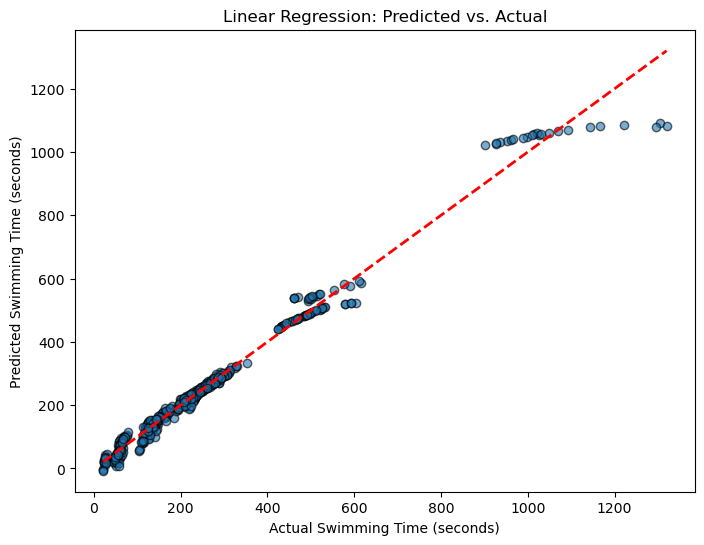

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test_no, y_pred_no, alpha=0.6, edgecolors='k')
plt.plot([y_test_no.min(), y_test_no.max()], [y_test_no.min(), y_test_no.max()], 'r--', lw=2)
plt.xlabel("Actual Swimming Time (seconds)")
plt.ylabel("Predicted Swimming Time (seconds)")
plt.title("Linear Regression: Predicted vs. Actual")
plt.show()


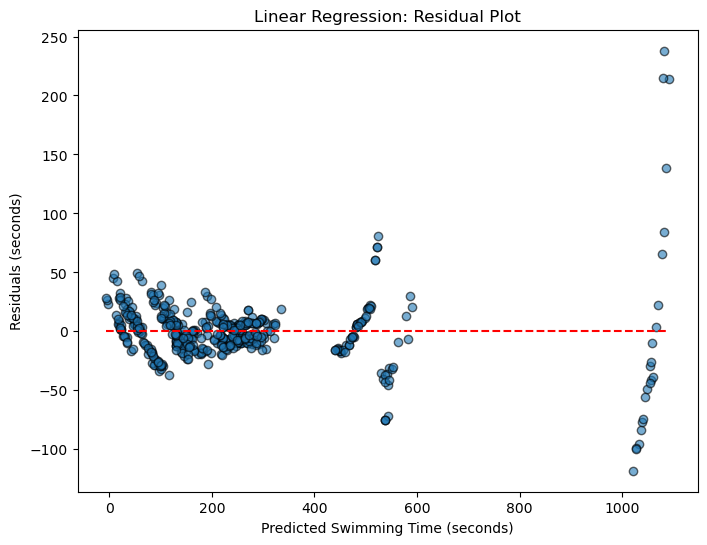

In [17]:
# Calculate residuals
residuals_lr = y_test_no - y_pred_no

plt.figure(figsize=(8,6))
plt.scatter(y_pred_no, residuals_lr, alpha=0.6, edgecolors='k')
plt.hlines(y=0, xmin=y_pred_no.min(), xmax=y_pred_no.max(), colors='r', linestyles='dashed')
plt.xlabel("Predicted Swimming Time (seconds)")
plt.ylabel("Residuals (seconds)")
plt.title("Linear Regression: Residual Plot")
plt.show()


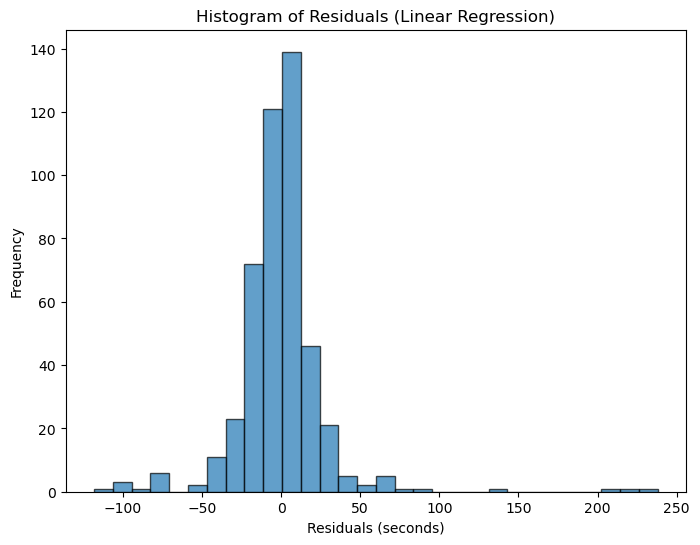

In [18]:
plt.figure(figsize=(8,6))
plt.hist(residuals_lr, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Residuals (seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals (Linear Regression)")
plt.show()


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd


# 'Ranking', 'Distance', 'Sex', 'Event', 'Time_seconds'

# Ensure 'Ranking_numeric' exists and drop rows with missing values
df_no_outliers['Ranking_numeric'] = pd.to_numeric(df_no_outliers['Ranking'], errors='coerce')
df_no_outliers = df_no_outliers.dropna(subset=['Ranking_numeric'])

# Define features and target
features = ['Ranking_numeric', 'Distance', 'Sex', 'Event']
target = 'Time_seconds'
X_no_outliers = df_no_outliers[features]
y_no_outliers = df_no_outliers[target]

# Define which features are numeric and which are categorical
numeric_features = ['Ranking_numeric', 'Distance']
categorical_features = ['Sex', 'Event']

# Create transformers for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the linear regression pipeline using LinearRegression()
pipeline_lr_no = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Perform 10-fold cross-validation for Linear Regression
cv_scores_lr = cross_val_score(pipeline_lr_no, X_no_outliers, y_no_outliers, cv=10, scoring='neg_mean_squared_error')
rmse_cv_lr = np.sqrt(-cv_scores_lr)
print("Linear Regression CV RMSE: {:.2f} ± {:.2f}".format(rmse_cv_lr.mean(), rmse_cv_lr.std()))


Linear Regression CV RMSE: 40.63 ± 26.57


In [26]:
import os
# Save linear regression predictions to CSV
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "linear_predictions.csv")
df_no_outliers[['Name', 'Predicted_Time_LR']].to_csv(downloads_path, index=False)
print("Linear predictions saved to:", downloads_path)


KeyError: "['Predicted_Time_LR'] not in index"